<font size=6><b> Setp01. EDA

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [64]:
from pandas.plotting import scatter_matrix

# ----------------- 학습 ----------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


# ----------------- 평가 ----------------------
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from scikitplot.metrics import plot_precision_recall_curve , plot_roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import Binarizer

# Data Load

In [65]:
train = pd.read_csv("./datasets/train.csv")
test  = pd.read_csv("./datasets/test.csv")
submit = pd.read_csv("./datasets/sample_submission.csv")

# ID

In [66]:
train['ID'].nunique(), train.shape

(30200, (30200, 14))

In [67]:
train = train.drop('ID', axis=1)
test  = test.drop('ID', axis=1)

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30200 entries, 0 to 30199
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   가입일      30200 non-null  int64  
 1   음성사서함이용  30200 non-null  int64  
 2   주간통화시간   30200 non-null  float64
 3   주간통화횟수   30200 non-null  int64  
 4   주간통화요금   30200 non-null  float64
 5   저녁통화시간   30200 non-null  float64
 6   저녁통화횟수   30200 non-null  int64  
 7   저녁통화요금   30200 non-null  float64
 8   밤통화시간    30200 non-null  float64
 9   밤통화횟수    30200 non-null  int64  
 10  밤통화요금    30200 non-null  float64
 11  상담전화건수   30200 non-null  int64  
 12  전화해지여부   30200 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 3.0 MB


In [69]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12943 entries, 0 to 12942
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   가입일      12943 non-null  int64  
 1   음성사서함이용  12943 non-null  int64  
 2   주간통화시간   12943 non-null  float64
 3   주간통화횟수   12943 non-null  int64  
 4   주간통화요금   12943 non-null  float64
 5   저녁통화시간   12943 non-null  float64
 6   저녁통화횟수   12943 non-null  int64  
 7   저녁통화요금   12943 non-null  float64
 8   밤통화시간    12943 non-null  float64
 9   밤통화횟수    12943 non-null  int64  
 10  밤통화요금    12943 non-null  float64
 11  상담전화건수   12943 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 1.2 MB


In [70]:
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


# target Feature
* <font color=red size=4><b> 불균형
* Churn rate(고객 이탈률)
    * 정해진 기간 내 이탈 고객을 전체 고객수로 나눈 수치

Churn rate 양성비율 : 10.986755
0    26882
1     3318
Name: 전화해지여부, dtype: int64


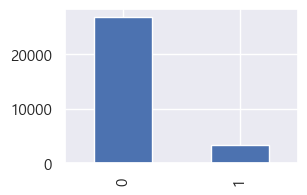

In [71]:
print( f"Churn rate 양성비율 : {len(train[train['전화해지여부']== 1]) / len(train) * 100 :2f}" )
print( train['전화해지여부'].value_counts() )
train['전화해지여부'].value_counts().plot(kind='bar', figsize=(3,2))
plt.show()



# 파생피쳐

## 가입일

In [72]:
train['가입일'].min(), train['가입일'].max()

(1, 2212)

* $ 지수화 = \frac {가입일} {가입일-시작일} * 100 $

In [73]:
traincp = train.copy()

In [74]:
# train['가입일지수'] = train['가입일'].apply(lambda d :  (d / (2213 -d )) * 100 )
train['가입기간년'] = train['가입일'] // 365
train['가입기간월'] = np.floor(train['가입일'] // 12)
train['가입기간주'] = np.floor(train['가입일'] // 52)
train['가입월']     = np.floor(train['가입일'] / 30) - (  ( np.floor(train['가입일'] / 30) / 12).astype(int) * 12  )  

test['가입기간년']  = test['가입일'] // 365
test['가입기간월']  = np.floor(test['가입일'] // 12)
test['가입기간주']  = np.floor(test['가입일'] // 52)
test['가입월']      = np.floor(test['가입일'] / 30) - (  ( np.floor(train['가입일'] / 30) / 12).astype(int) * 12  )  

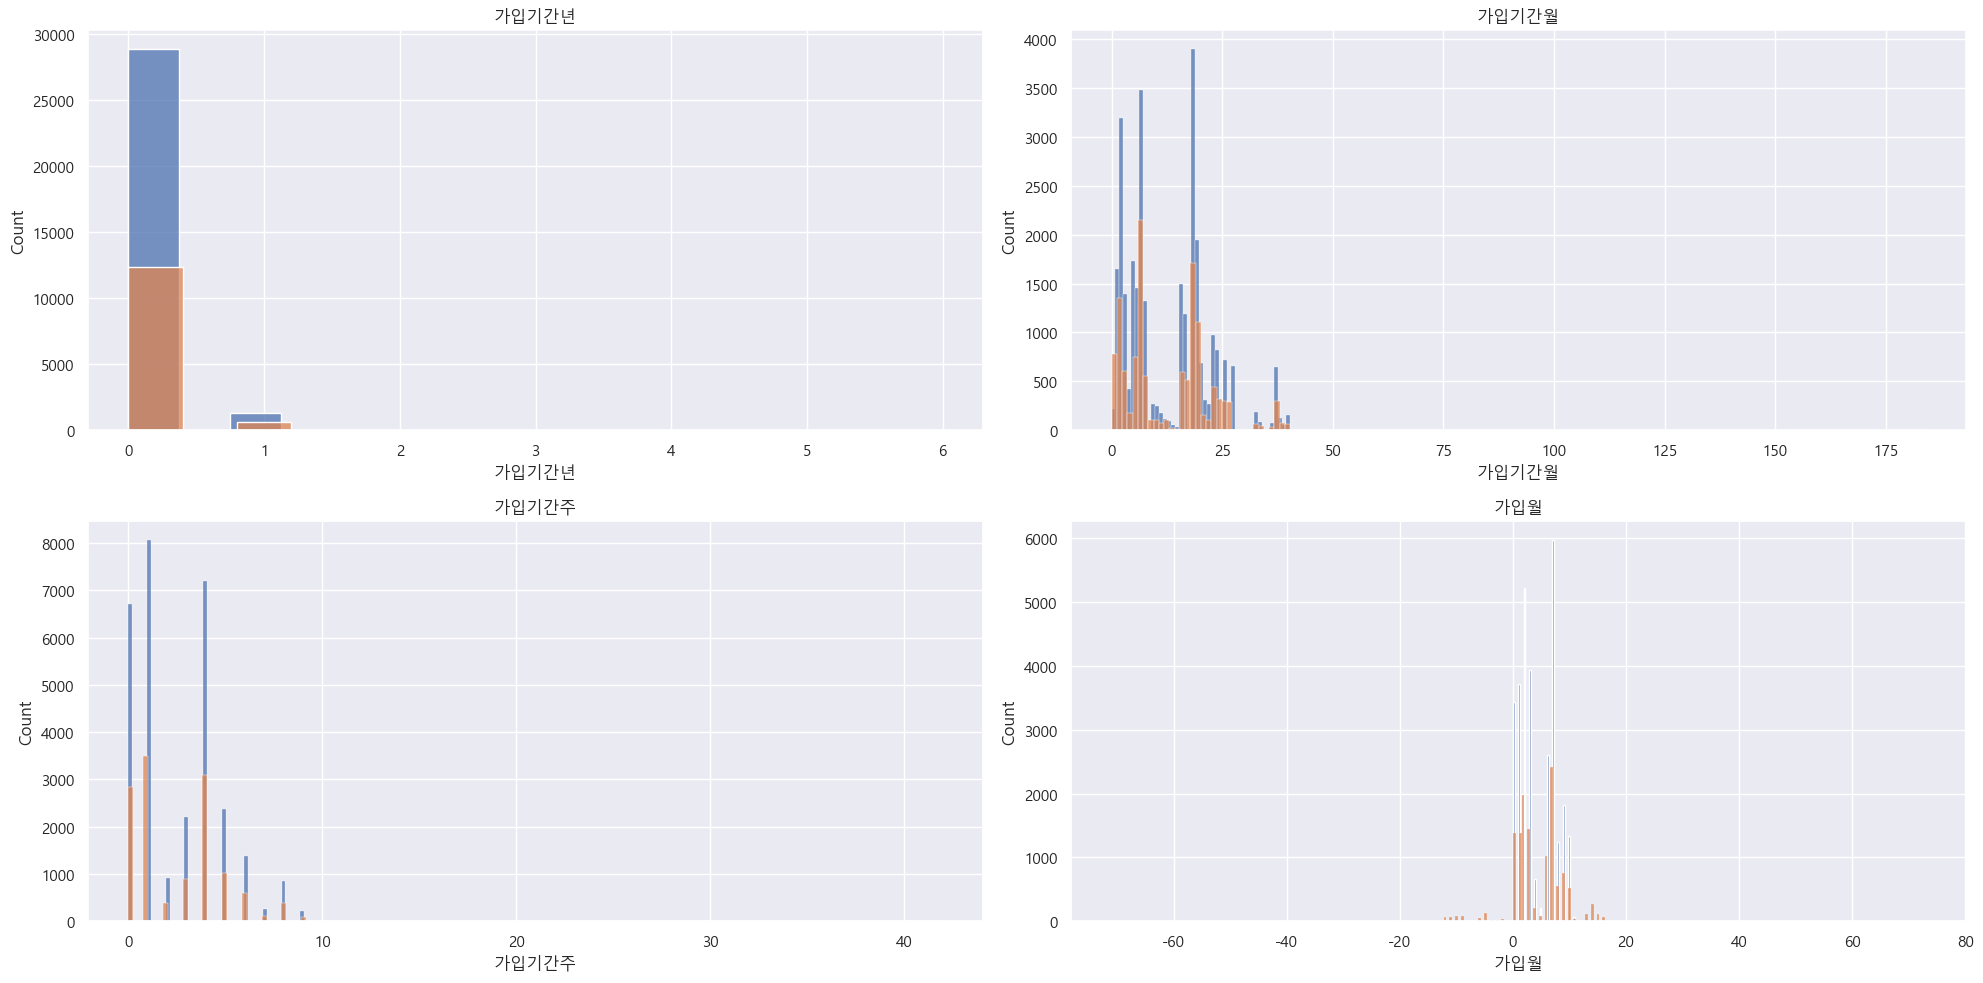

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10)  ) 

for i, col in enumerate(['가입기간년','가입기간월','가입기간주','가입월']) :
    r = i//2
    c = i%2
    axes[r][c].set_title(col)
    sns.histplot(data=train, x=col, ax=axes[r][c])
    sns.histplot(data=test, x=col, ax=axes[r][c])

plt.tight_layout()
plt.show()

## 가입기간년

* 가입년수 2년 이상이면 해지 확률이 거의 없다

In [76]:
train[['가입기간년','전화해지여부']].value_counts().sort_index()

가입기간년  전화해지여부
0      0         25636
       1          3192
1      0          1219
       1           123
2      0             4
       1             1
3      0             6
5      0            11
       1             2
6      0             6
dtype: int64

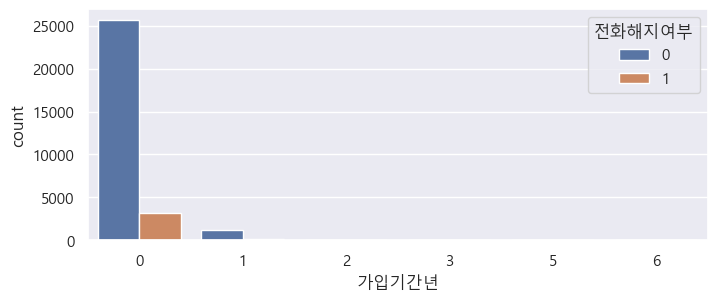

In [77]:
plt.figure(figsize=(8,3))
sns.countplot(data=train    , x='가입기간년',  hue="전화해지여부")
plt.show()

## 가입기간월

In [78]:
train[['가입기간월']].value_counts().sort_index()

가입기간월
0.0       218
1.0      1650
2.0      3195
3.0      1393
4.0       421
5.0      1726
6.0      1455
7.0      3479
8.0      1321
9.0       271
10.0      244
11.0      180
12.0      119
13.0       96
14.0       53
15.0       37
16.0     1492
17.0     1187
18.0     3895
19.0     1950
20.0      686
21.0      308
22.0      266
23.0      974
24.0      823
25.0        6
26.0      722
27.0      661
33.0      185
34.0       84
36.0       71
37.0      649
38.0      129
39.0       49
40.0      159
41.0       16
75.0        4
76.0        1
92.0        6
167.0       4
175.0       6
176.0       3
184.0       6
dtype: int64

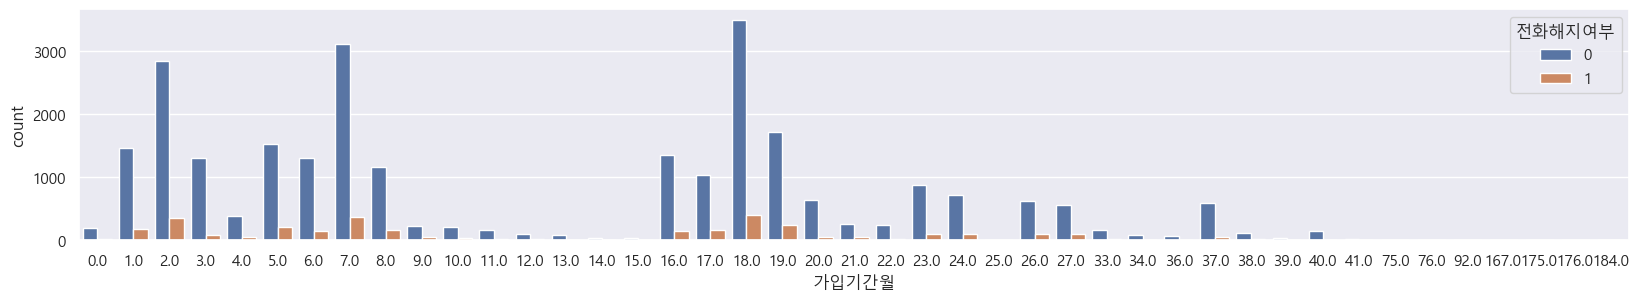

In [79]:
plt.figure(figsize=(20,3))
sns.countplot(data=train    , x='가입기간월', hue="전화해지여부")
plt.show()

## 가입기간주

* 가입기간 17주 이상이면 해지 확률이 거의 없다

In [80]:
train[['가입기간주','전화해지여부']].value_counts().sort_index()

가입기간주  전화해지여부
0.0    0         6044
       1          666
1.0    0         7161
       1          894
2.0    0          778
       1          129
3.0    0         1968
       1          229
4.0    0         6404
       1          795
5.0    0         2099
       1          278
6.0    0         1182
       1          201
7.0    0          244
       1           25
8.0    0          771
       1           78
9.0    0          204
       1           20
17.0   0            4
       1            1
21.0   0            6
38.0   0            2
       1            2
40.0   0            9
42.0   0            6
dtype: int64

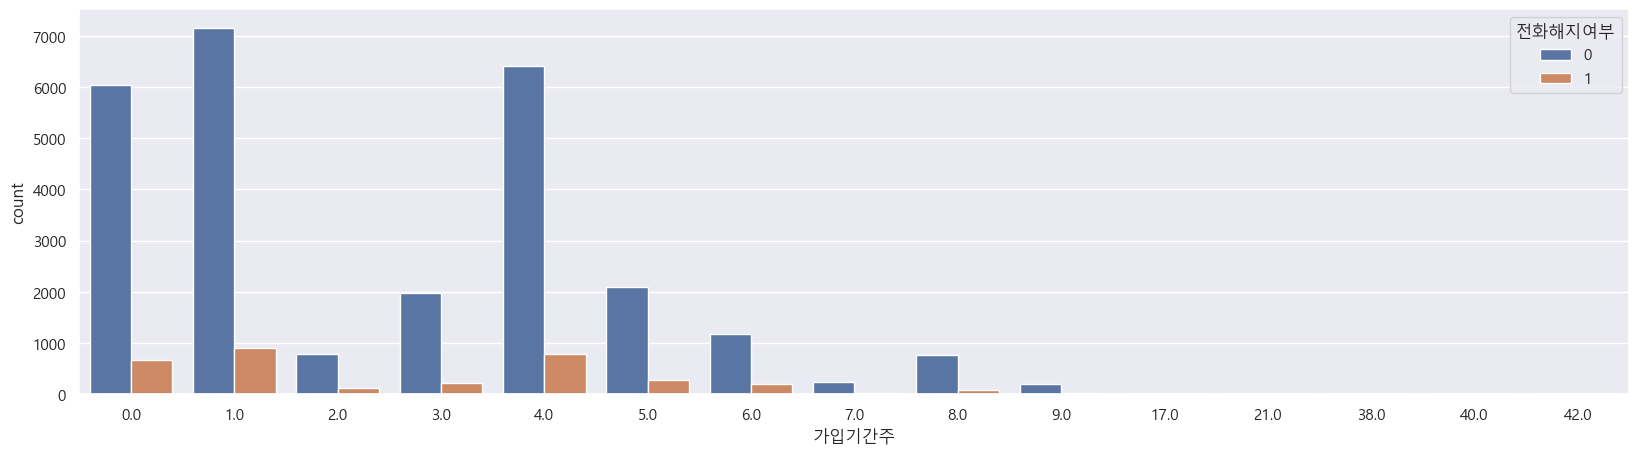

In [81]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='가입기간주', hue="전화해지여부")
plt.show()

## 가입월

* 가입/해지 실적이 저조한 달이 있다
    * 4, 5, 11월 : 매우 저조 
    * 8, 9, 10월 : 상대적 저조 

In [82]:
train[['가입월','전화해지여부']].value_counts().sort_index()

가입월   전화해지여부
0.0   0         3074
      1          364
1.0   0         3368
      1          352
2.0   0         4698
      1          525
3.0   0         3443
      1          484
4.0   0          589
      1           77
5.0   0          170
      1           31
6.0   0         2313
      1          294
7.0   0         5302
      1          661
8.0   0         1123
      1          120
9.0   0         1605
      1          209
10.0  0         1145
      1          189
11.0  0           52
      1           12
dtype: int64

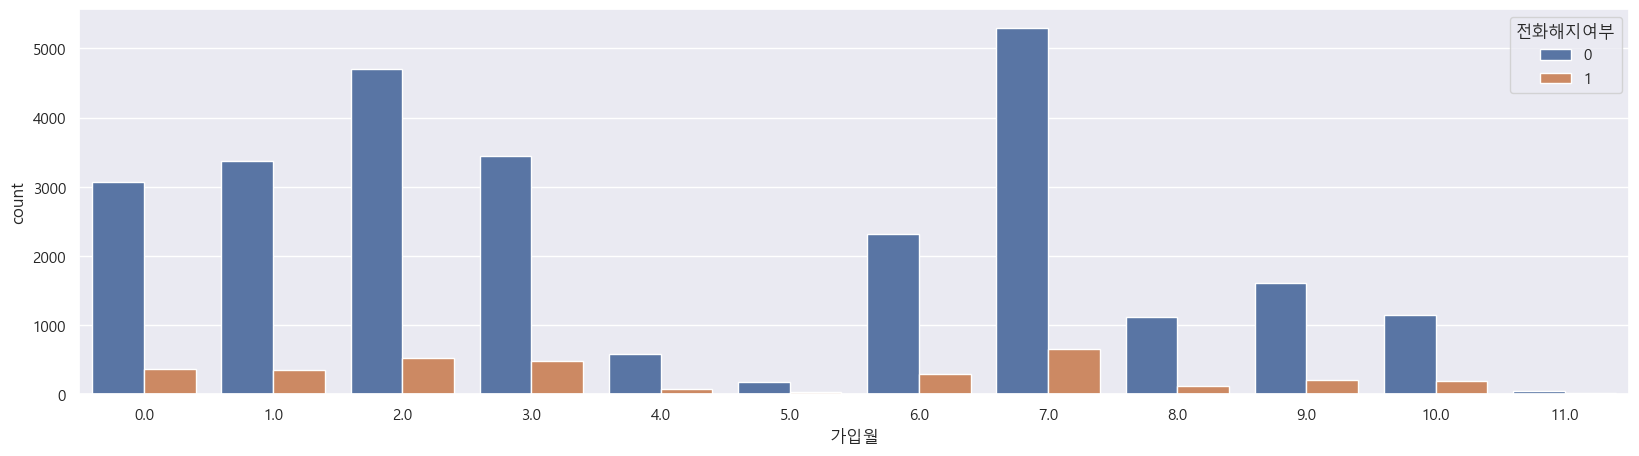

In [83]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='가입월', hue="전화해지여부")
plt.show()

## 통화 시간/횟수/요금
* 전체 시간, 횟수, 요금
* 단위 시간당 요금
* 1회 통화 시간

In [84]:
train['총통화시간']   = train['주간통화시간'] + train['저녁통화시간'] + train['밤통화시간']
train['총통화횟수']   = train['주간통화횟수'] + train['저녁통화횟수'] + train['밤통화횟수']
train['총통화요금']   = train['주간통화요금'] + train['저녁통화요금'] + train['밤통화요금']
train['시간당요금']   = train['총통화요금']   / train['총통화시간']
train['횟수당시간']   = train['총통화시간']   / train['총통화횟수']


test['총통화시간']   = test['주간통화시간'] + test['저녁통화시간'] + test['밤통화시간']
test['총통화횟수']   = test['주간통화횟수'] + test['저녁통화횟수'] + test['밤통화횟수']
test['총통화요금']   = test['주간통화요금'] + test['저녁통화요금'] + test['밤통화요금']
test['시간당요금']   = test['총통화요금']   / test['총통화시간']
test['횟수당시간']   = test['총통화시간']   / test['총통화횟수']

# 음성사서함이용

In [85]:
train[['음성사서함이용','전화해지여부']].value_counts().sort_index()

음성사서함이용  전화해지여부
0        0         9651
         1         1337
1        0         9439
         1         1413
2        0            4
                   ... 
117      1            1
211      0            2
212      0            4
1111     0            2
1112     0            1
Length: 125, dtype: int64

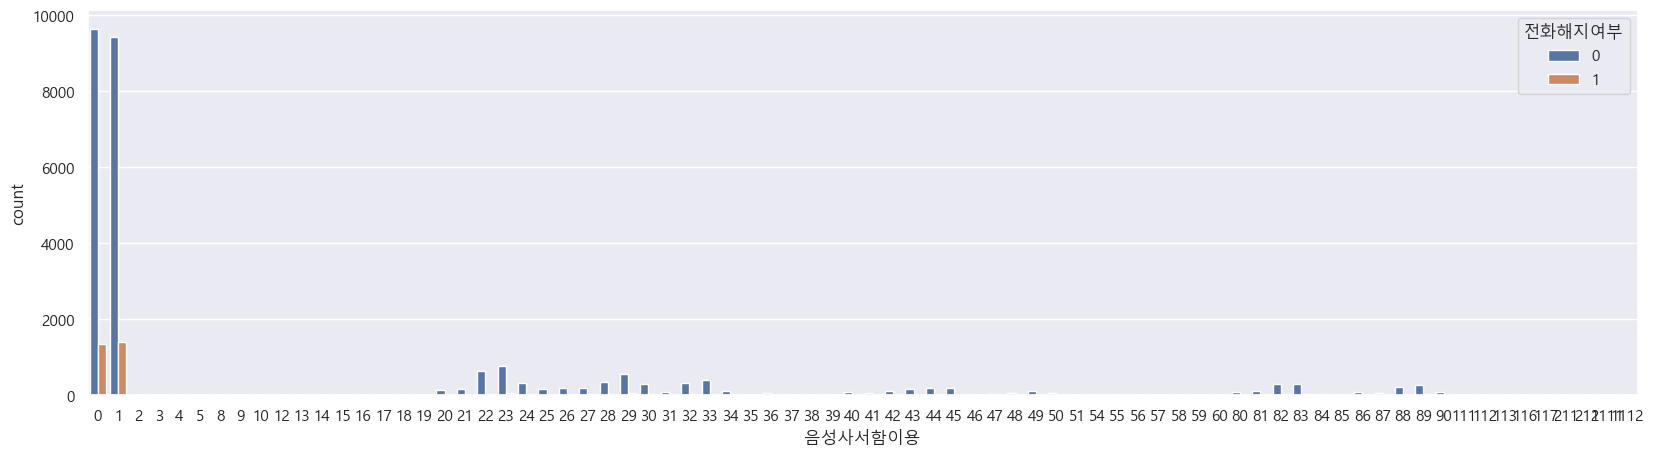

In [86]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='음성사서함이용', hue="전화해지여부")
plt.show()

# 상담전화건수

In [87]:
train[['상담전화건수','전화해지여부']].value_counts().sort_index()

상담전화건수  전화해지여부
0       0          5696
        1           607
1       0           754
        1            80
2       0         14844
        1          1678
3       0           986
        1           194
4       0          2288
        1           252
5       0           176
        1            58
6       0            91
        1           112
7       0             6
        1             7
8       0          2021
        1           313
9       0             3
        1            15
11      0            17
        1             2
dtype: int64

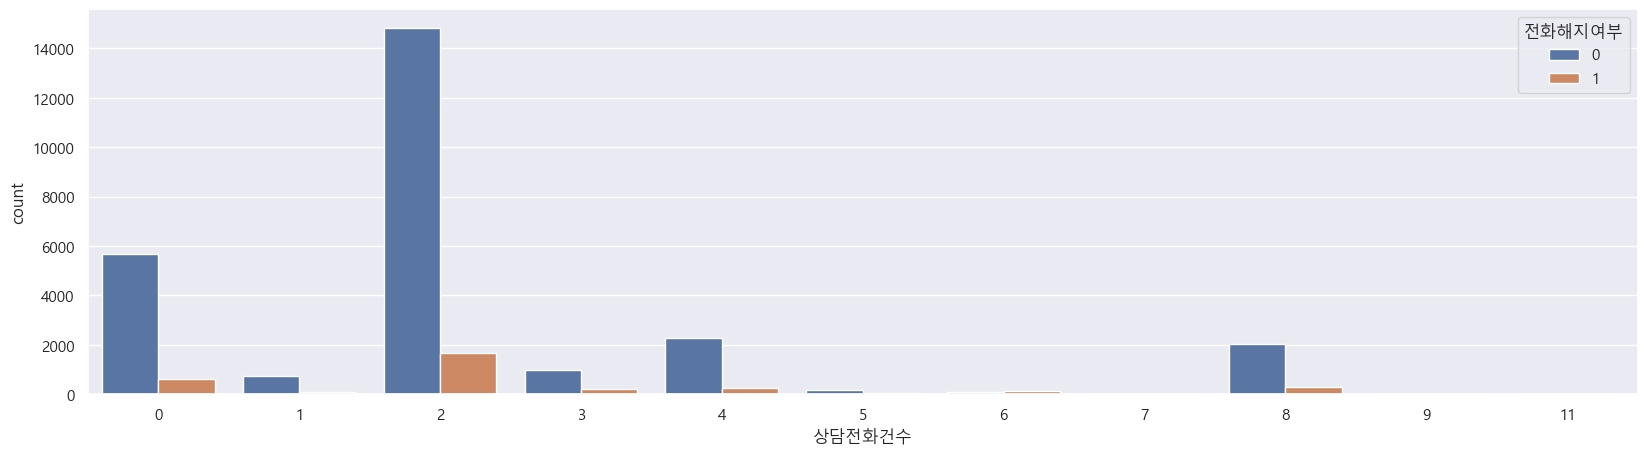

In [88]:
plt.figure(figsize=(20,5))
sns.countplot(data=train    , x='상담전화건수', hue="전화해지여부")
plt.show()

* 월별 상담전화건수

In [89]:
train.groupby(['가입기간월','전화해지여부'])['상담전화건수'].mean()

가입기간월  전화해지여부
0.0    0         2.707921
       1         3.562500
1.0    0         1.993852
       1         2.419355
2.0    0         2.052446
       1         2.347458
3.0    0         1.977727
       1         2.241758
4.0    0         2.668435
       1         2.772727
5.0    0         2.377383
       1         2.053659
6.0    0         2.402757
       1         2.919463
7.0    0         2.401219
       1         2.667590
8.0    0         2.367876
       1         3.134969
9.0    0         1.504464
       1         2.787234
10.0   0         1.417062
       1         1.666667
11.0   0         1.462025
       1         1.818182
12.0   0         1.445545
       1         2.666667
13.0   0         1.458824
       1         1.545455
14.0   0         1.372093
       1         2.200000
15.0   0         1.382353
       1         1.000000
16.0   0         2.225111
       1         2.513699
17.0   0         2.374394
       1         3.160256
18.0   0         2.069381
       1         2.52579

In [90]:
temp = train.groupby(['가입기간월','전화해지여부'])['상담전화건수'].mean().reset_index()
temp.head()

,가입기간월,전화해지여부,상담전화건수
0,0.0,0,2.707921
1,0.0,1,3.562500
2,1.0,0,1.993852
3,1.0,1,2.419355
4,2.0,0,2.052446


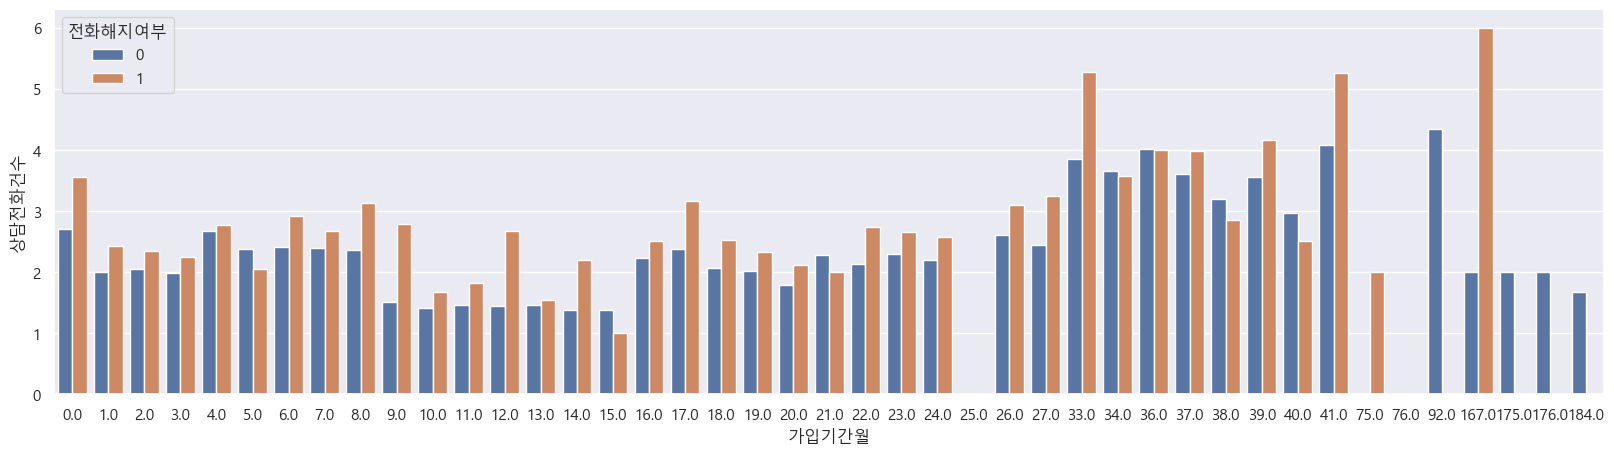

In [91]:
plt.figure(figsize=(20,5))
sns.barplot(data=temp    , x='가입기간월', y='상담전화건수', hue="전화해지여부")
plt.show()

# 히스토그램

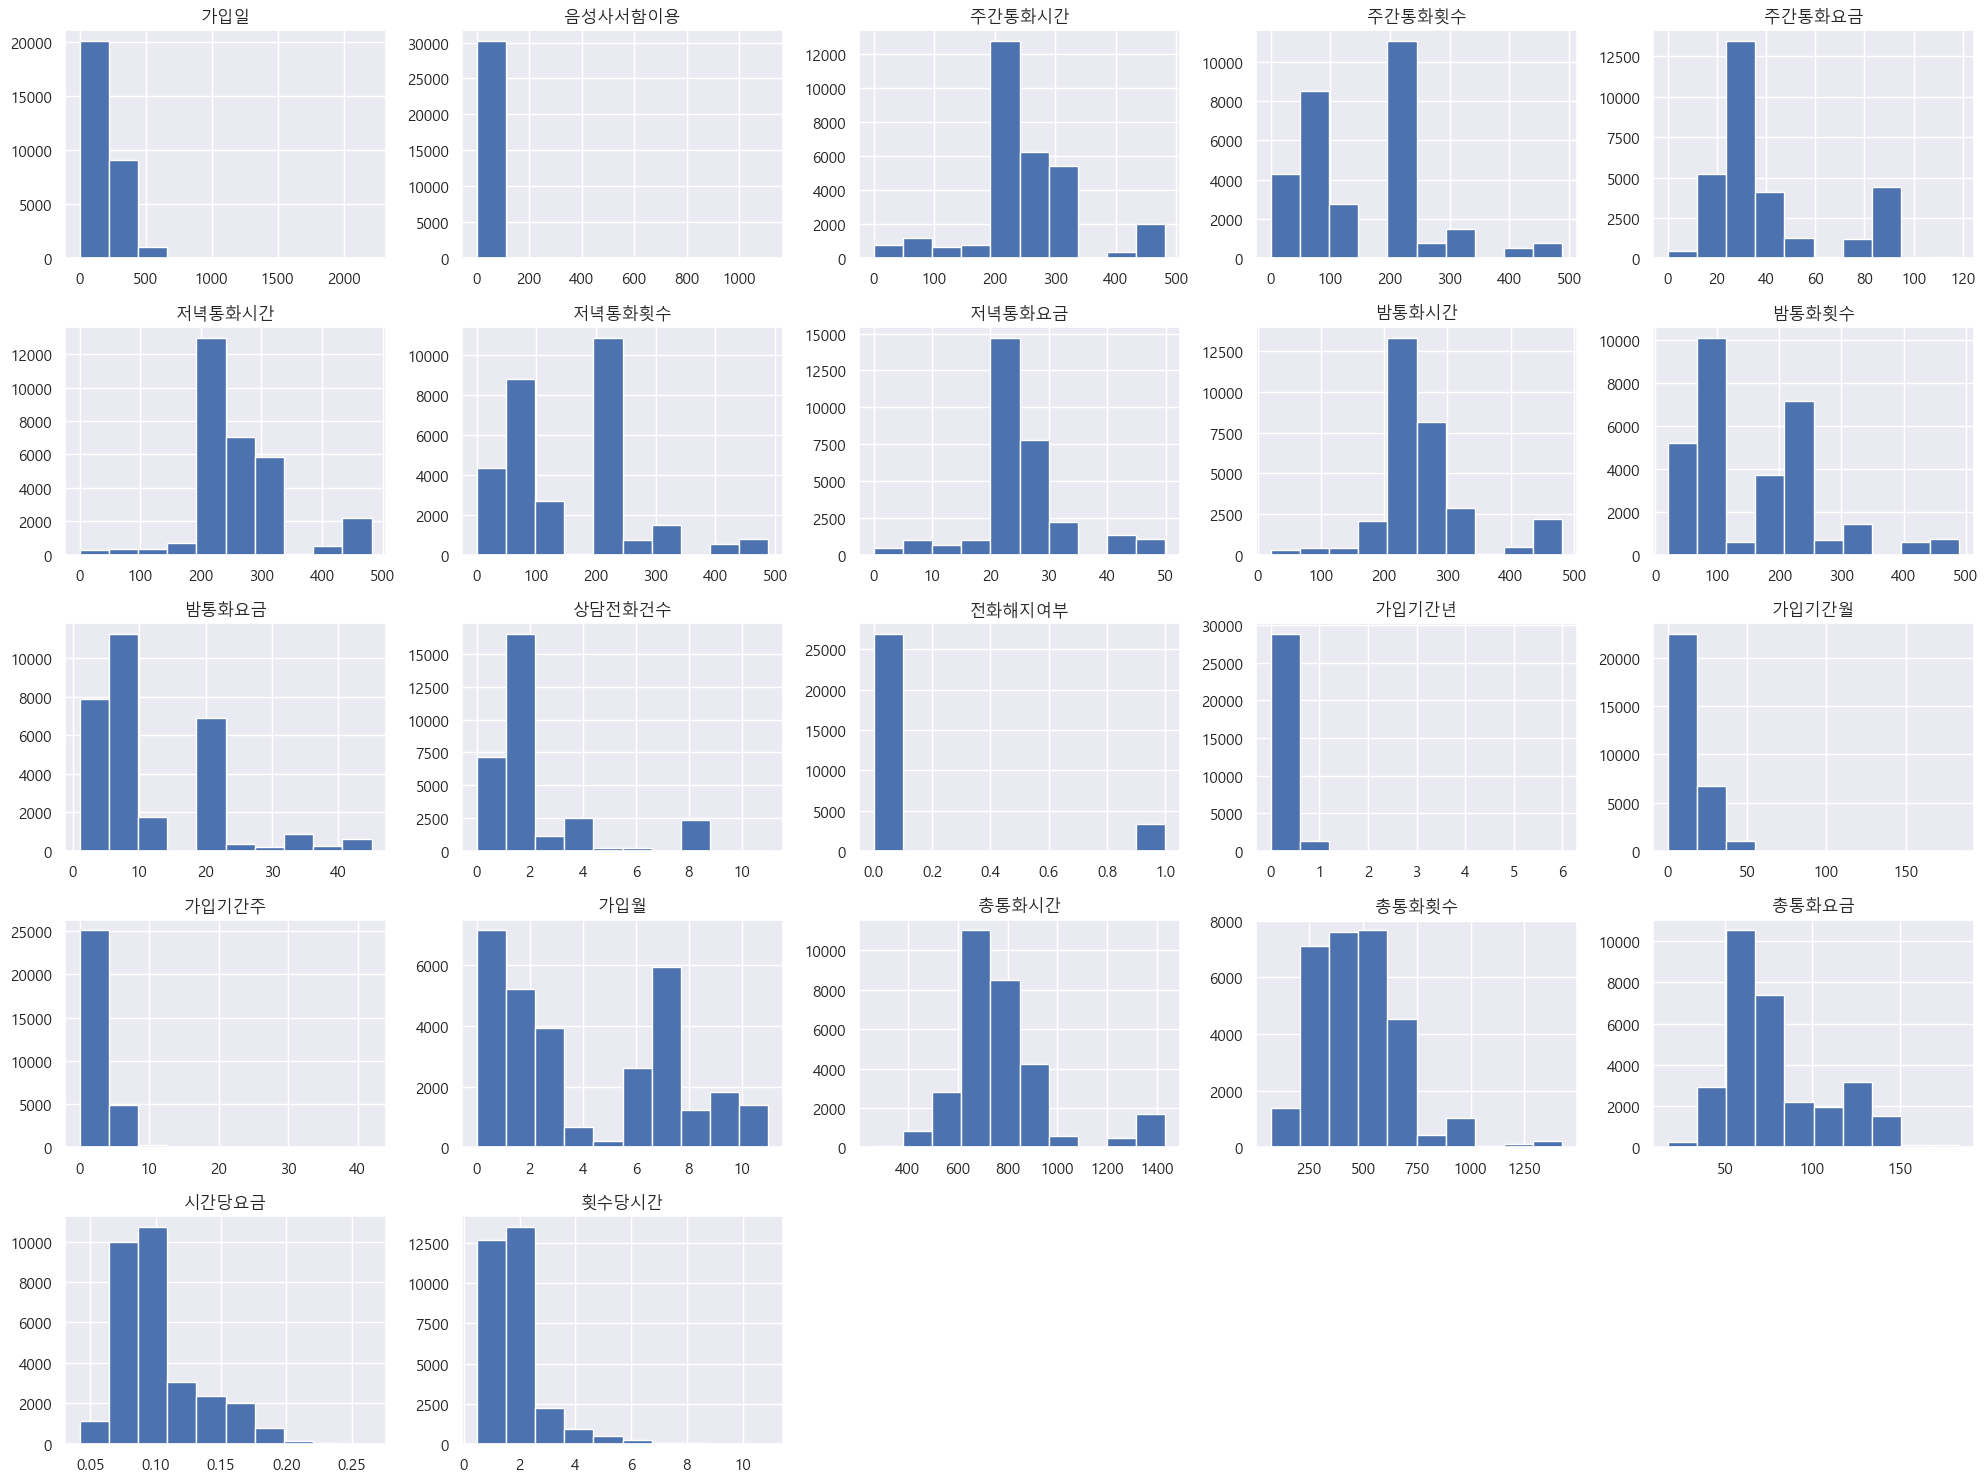

In [92]:
train.hist(figsize=(20,15))
plt.tight_layout()
plt.show()

In [93]:
len(train.columns), len(test.columns)

(22, 21)

# train test 분포

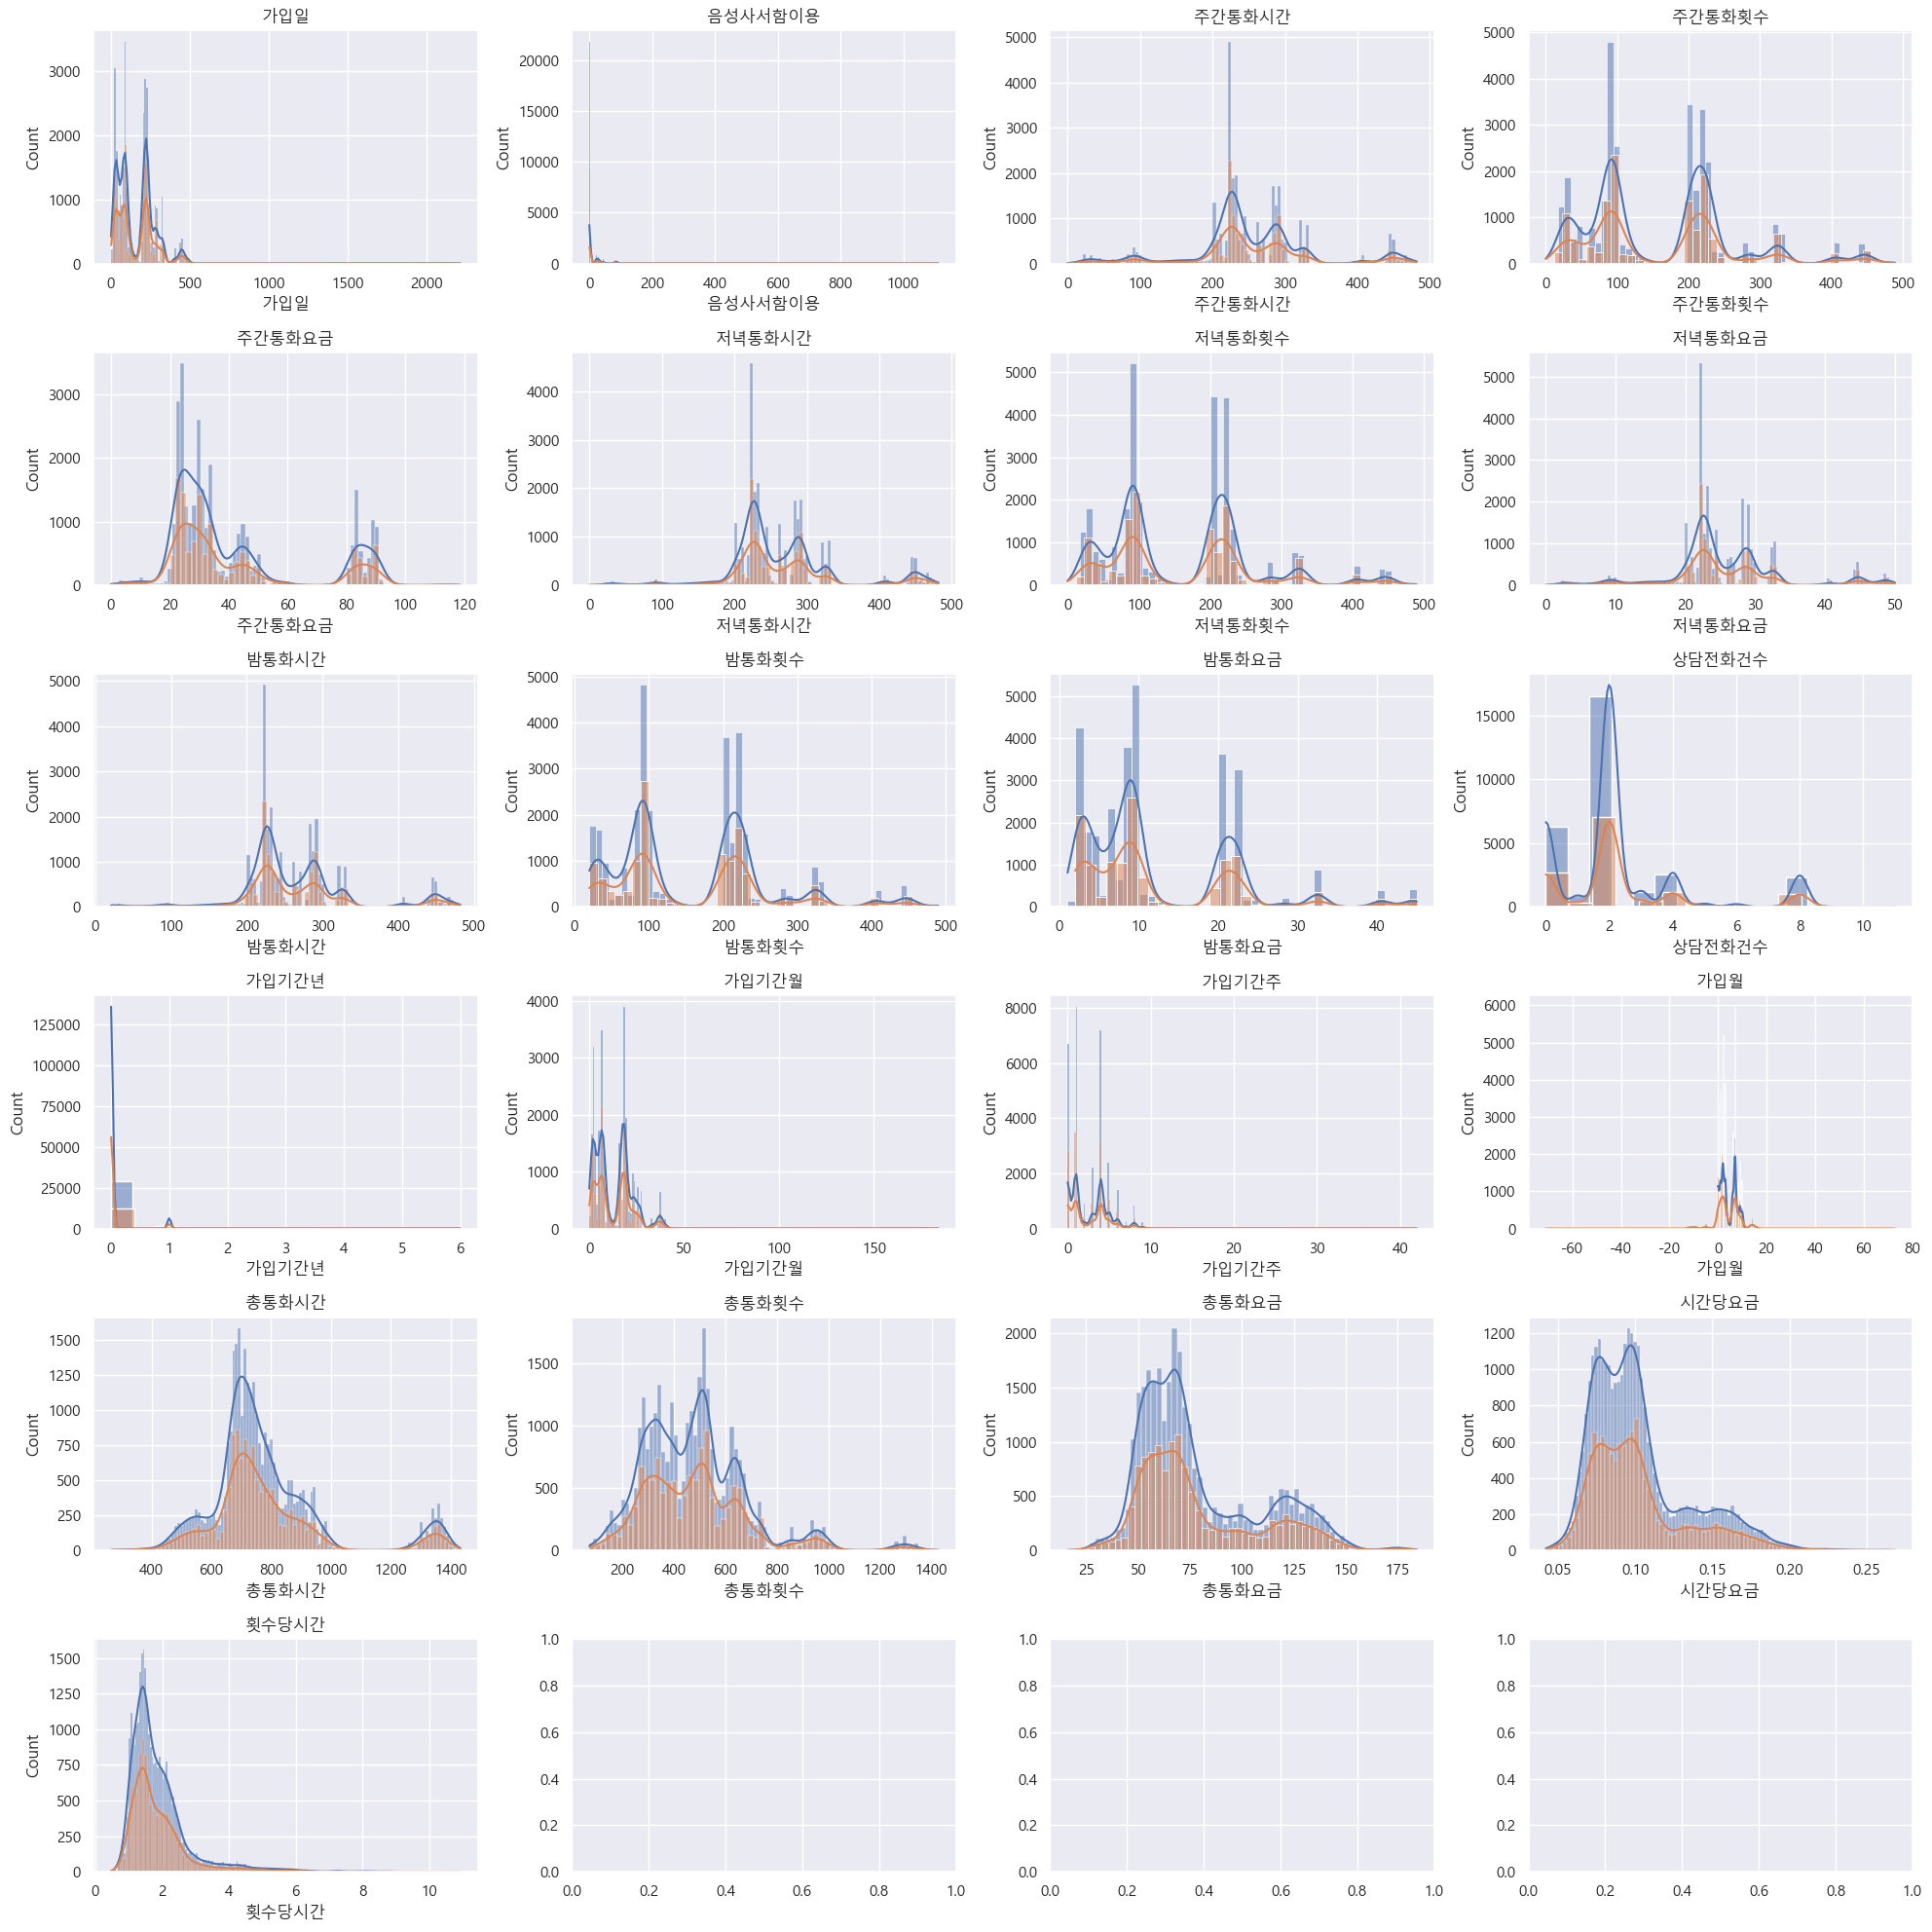

In [94]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20)  ) 

for i, col in enumerate(test.columns) :
    r = i//4
    c = i%4
    axes[r][c].set_title(col)
    sns.histplot(data=train, x=col, ax=axes[r][c],  kde=True )
    sns.histplot(data=test, x=col, ax=axes[r][c],   kde=True )

plt.tight_layout()
plt.show()


# train 0 , 1 분포

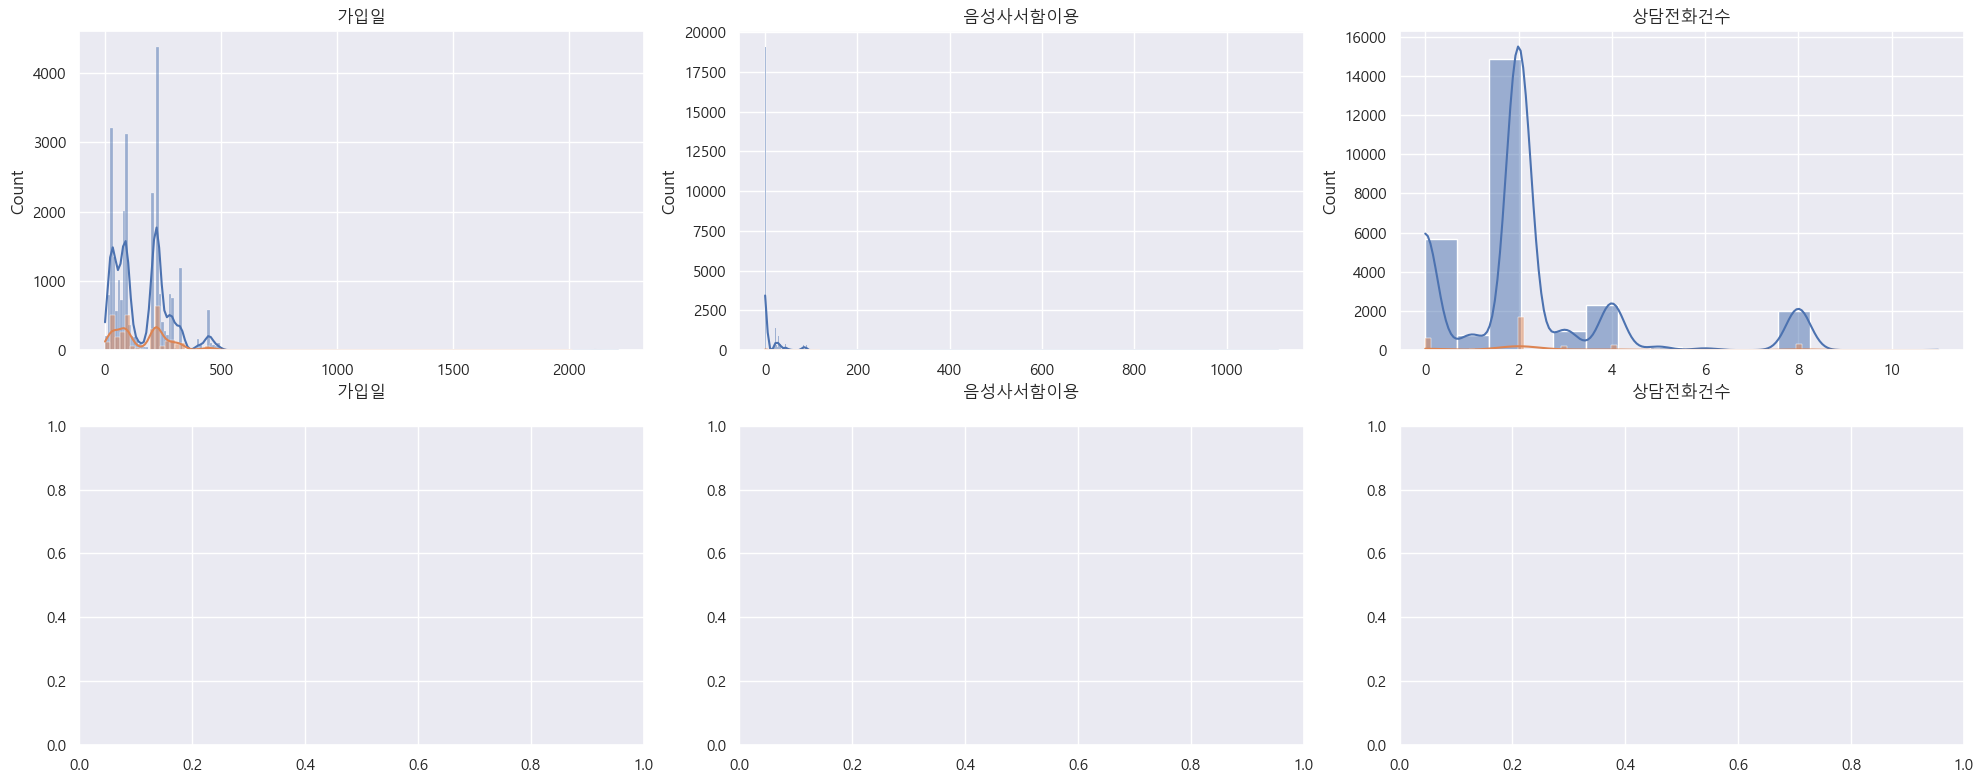

In [95]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8)  ) 

for i, col in enumerate(['가입일','음성사서함이용','상담전화건수']) :
    r = i//3
    c = i%3
    axes[r][c].set_title(col)
    sns.histplot(data=train[train['전화해지여부']==0], x=col, ax=axes[r][c],     kde=True )
    sns.histplot(data=train[train['전화해지여부']==1], x=col, ax=axes[r][c],     kde=True )

plt.tight_layout()
plt.show()


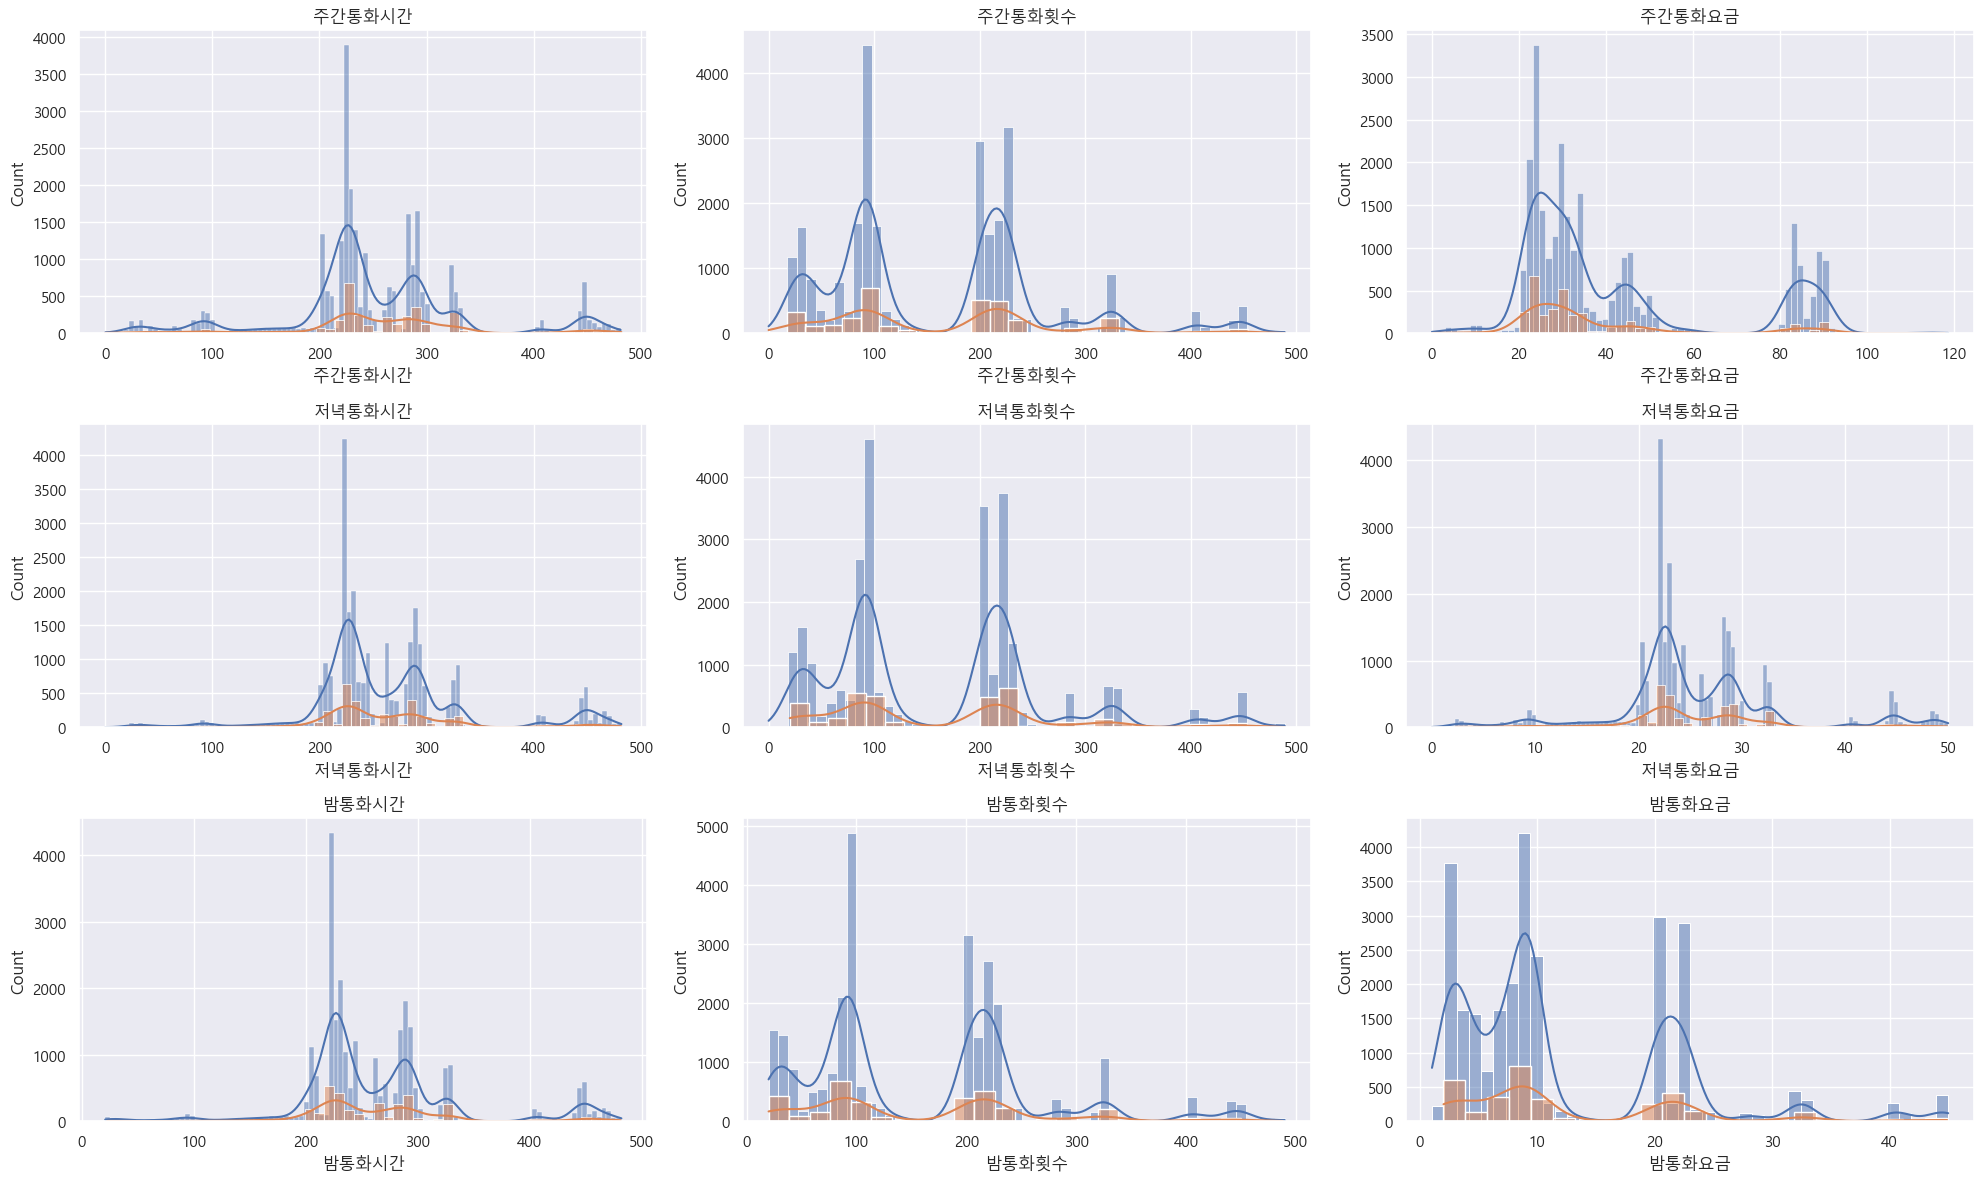

In [96]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12)  ) 

for i, col in enumerate(['주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금']) :
    r = i//3
    c = i%3
    axes[r][c].set_title(col)
    sns.histplot(data=train[train['전화해지여부']==0], x=col, ax=axes[r][c],     kde=True )
    sns.histplot(data=train[train['전화해지여부']==1], x=col, ax=axes[r][c],     kde=True )

plt.tight_layout()
plt.show()

* 주간,저녁,밤 : 통화시간 통화횟수는 비슷한 패턴을 보인다
* <b>주간,저녁,밤 : 통화요금은 다른 패턴을 보인다 --> 요금제????

# 박스플롯 (아웃라이어)

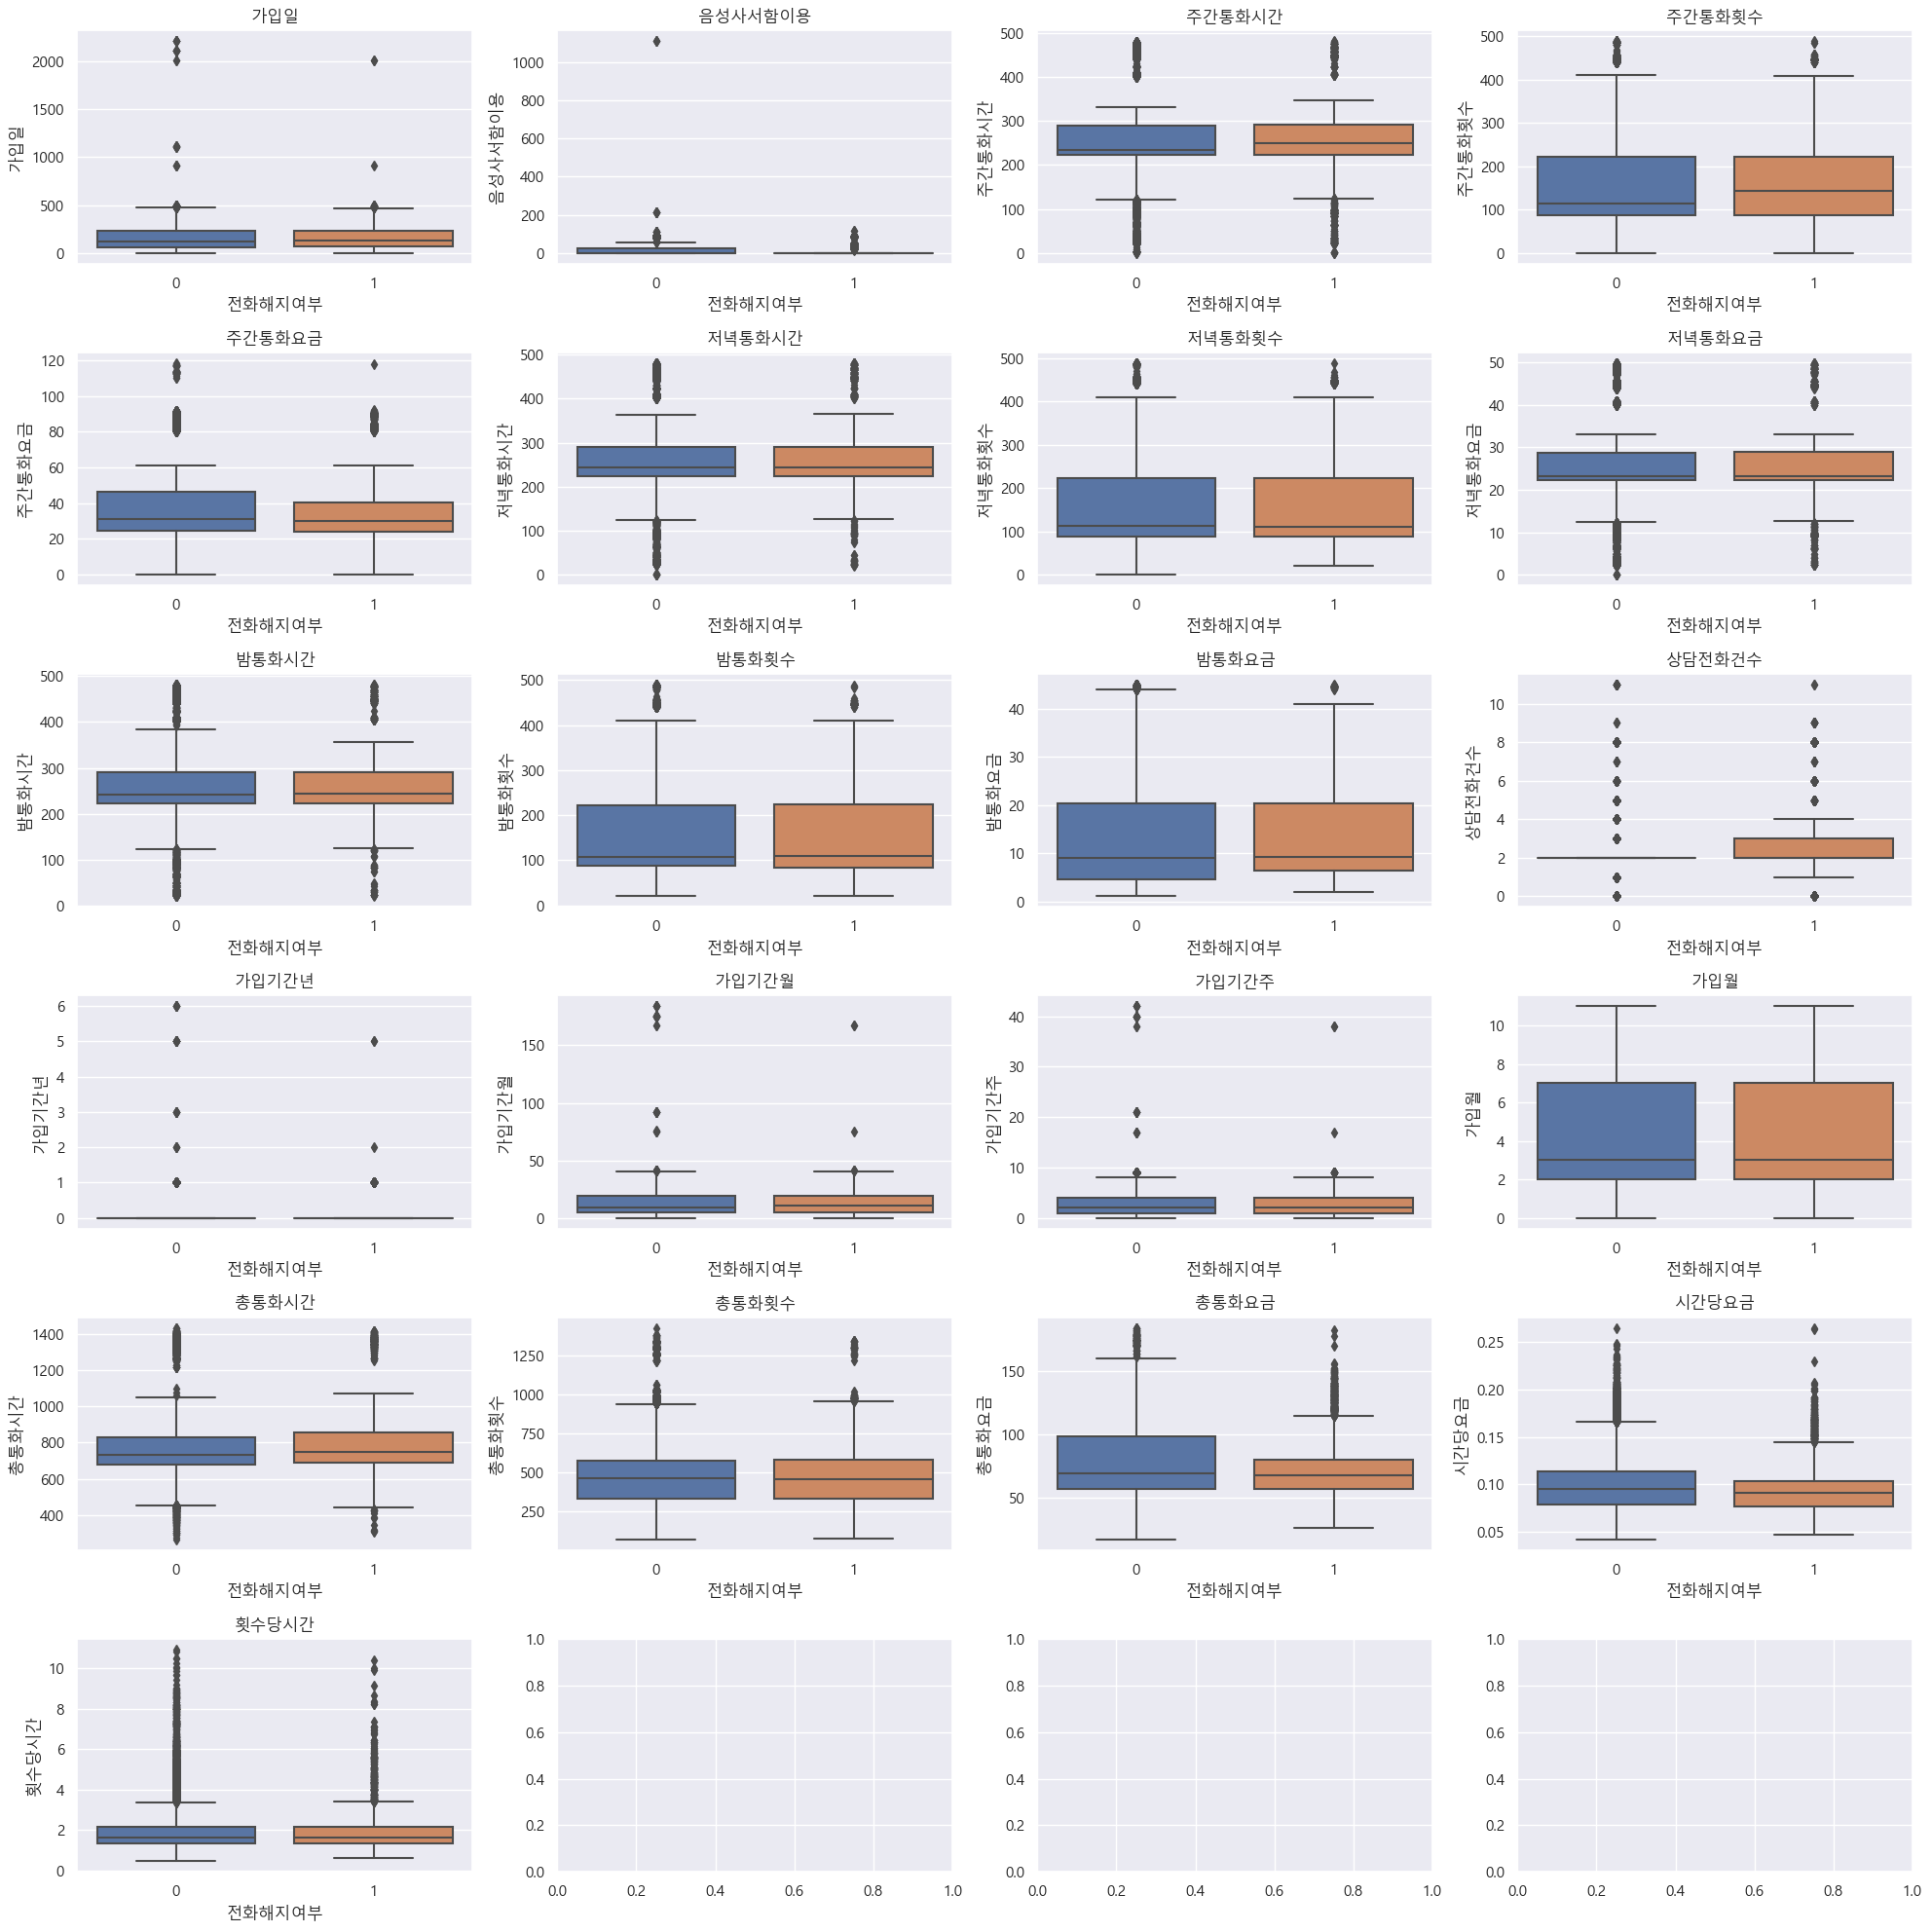

In [97]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20,20))

for i, col in enumerate(test.columns) :
    r = i//4
    c = i%4
    sns.boxplot(data=train, y=col, x="전화해지여부", ax=axes[r][c])
    axes[r][c].set_title(col) 
plt.tight_layout()    
plt.show()

# 데이터 분포(scatter)

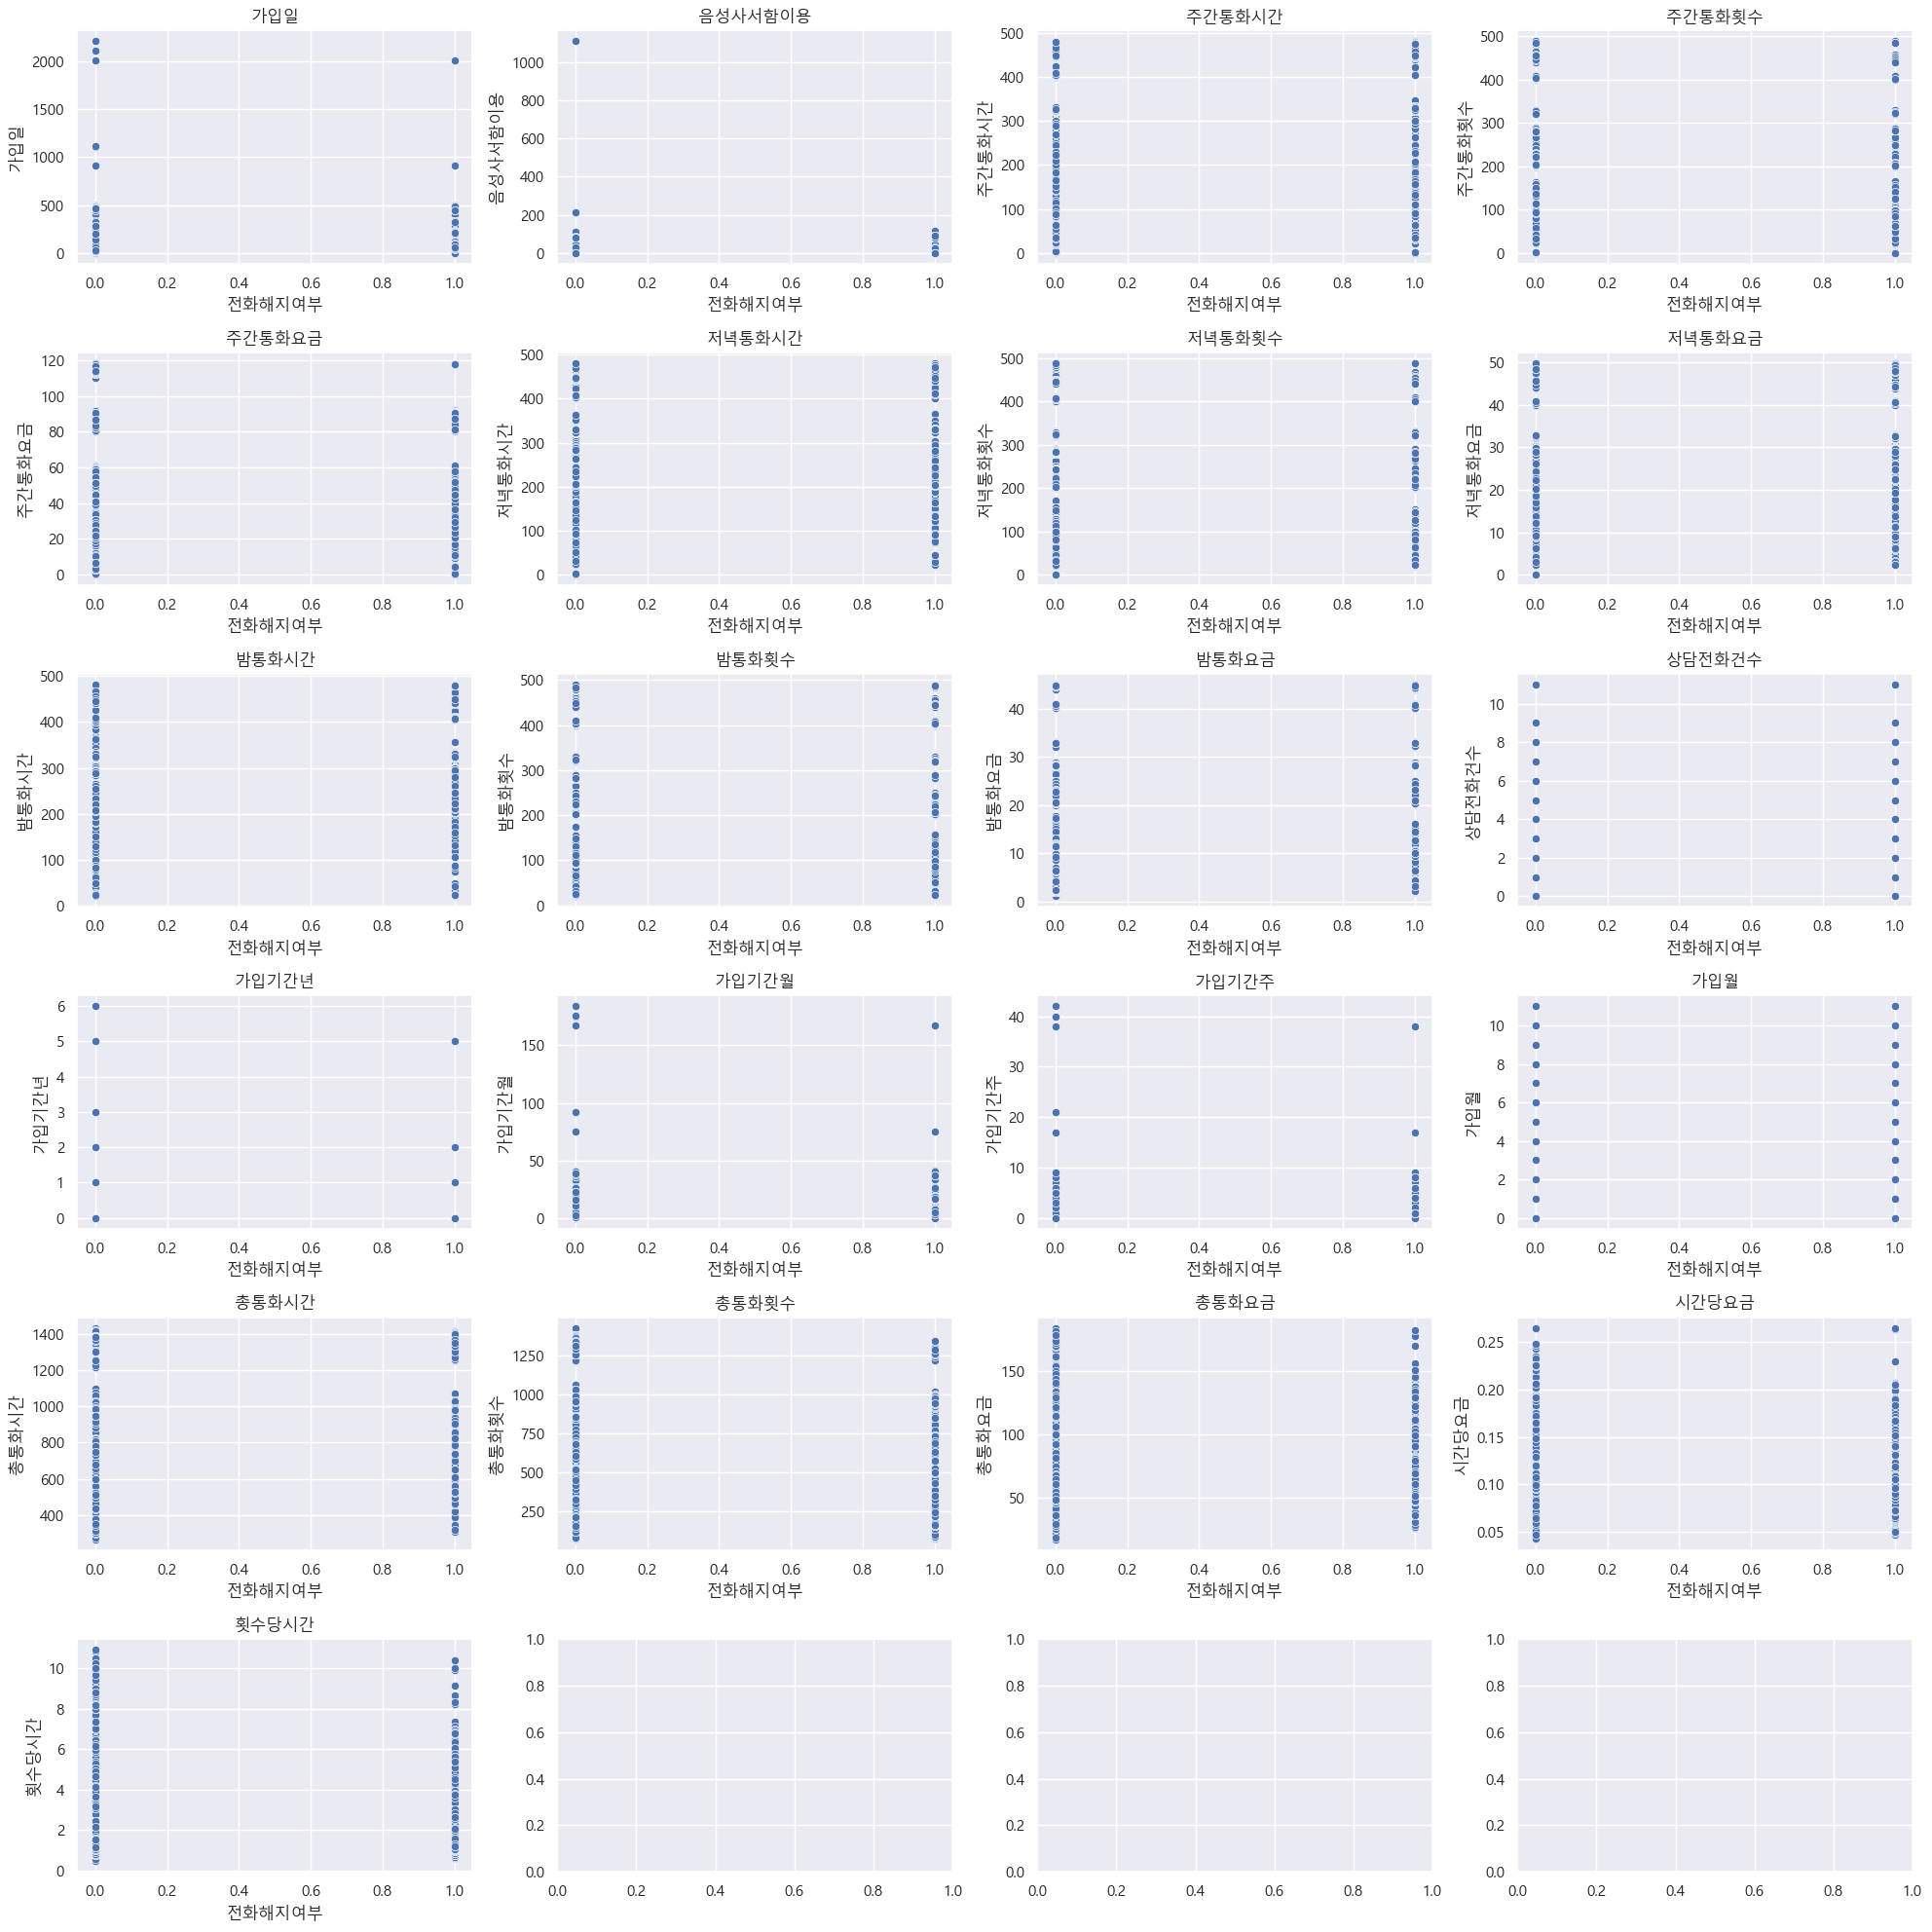

In [98]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20,20))

for i, col in enumerate(test.columns) :
    r = i//4
    c = i%4
    sns.scatterplot(data=train, x='전화해지여부' , y=col, ax=axes[r][c])
    axes[r][c].set_title(col) 
plt.tight_layout()    
plt.show()

# 상관분석

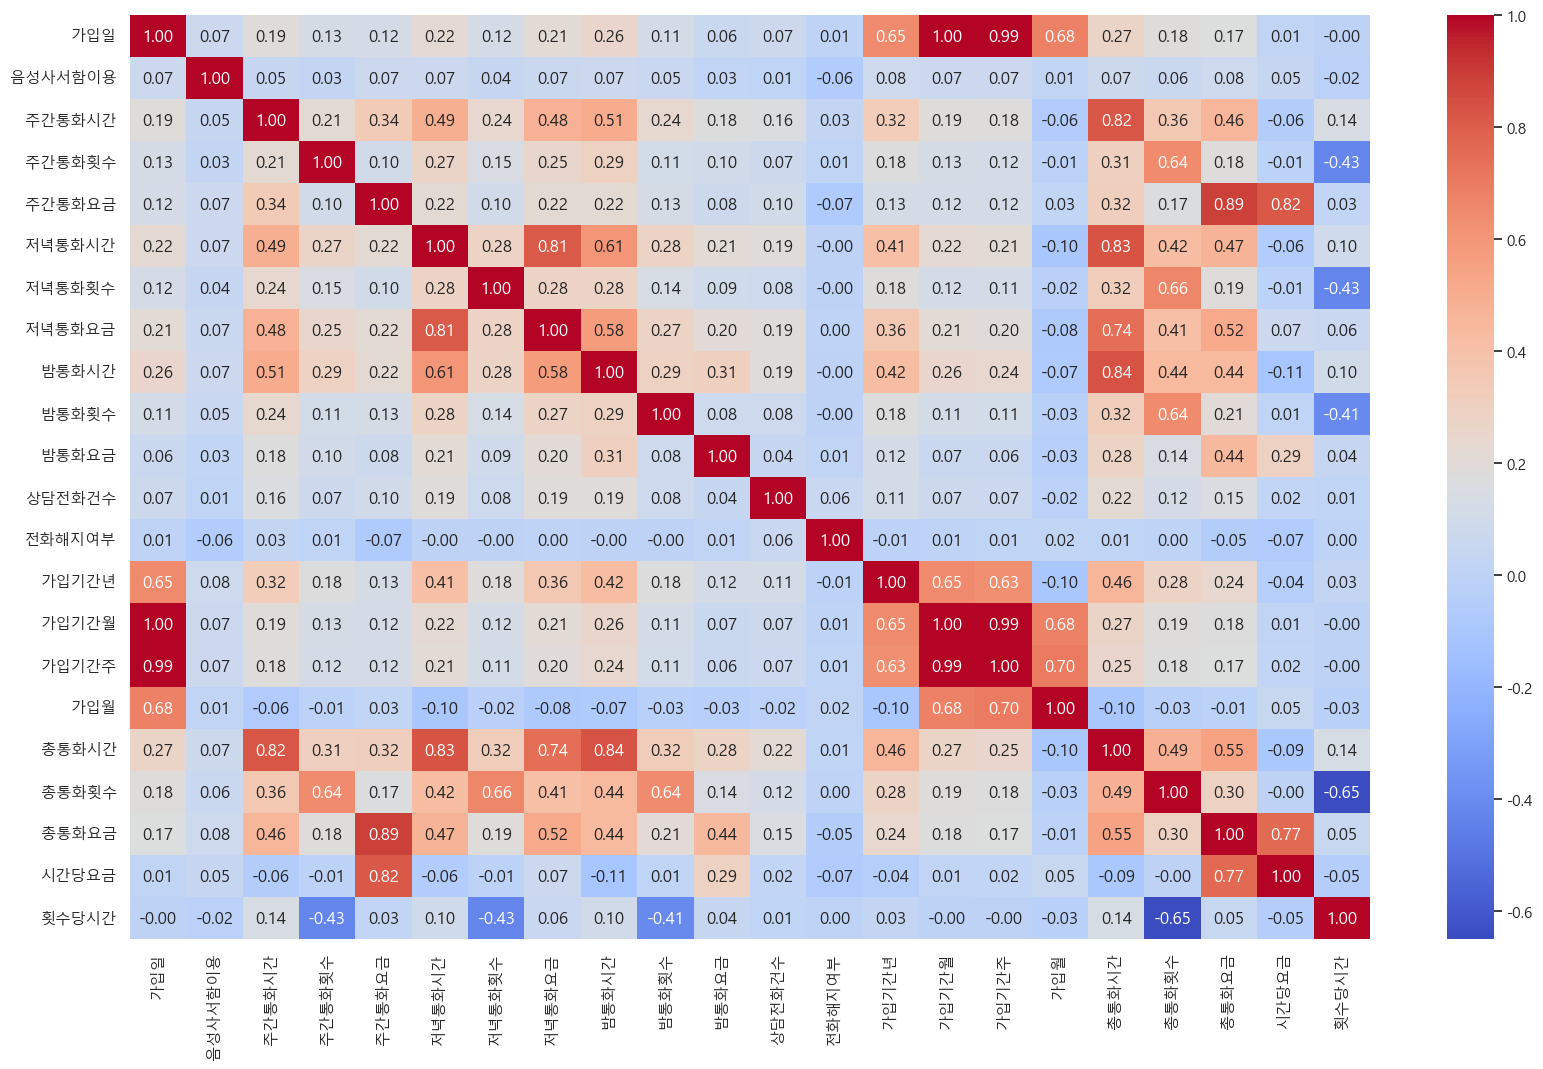

In [99]:
plt.figure(figsize=(20,12))
sns.heatmap(train.corr(), fmt=".2f", annot=True, cmap="coolwarm")
plt.show()

In [100]:
train.columns

Index(['가입일', '음성사서함이용', '주간통화시간', '주간통화횟수', '주간통화요금', '저녁통화시간', '저녁통화횟수',
       '저녁통화요금', '밤통화시간', '밤통화횟수', '밤통화요금', '상담전화건수', '전화해지여부', '가입기간년',
       '가입기간월', '가입기간주', '가입월', '총통화시간', '총통화횟수', '총통화요금', '시간당요금', '횟수당시간'],
      dtype='object')

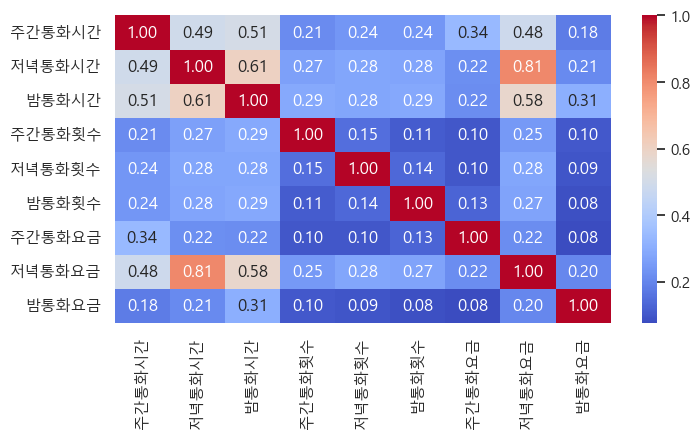

In [101]:
plt.figure(figsize=(8,4))
sns.heatmap(train[['주간통화시간', '저녁통화시간', '밤통화시간', '주간통화횟수','저녁통화횟수', '밤통화횟수',  '주간통화요금','저녁통화요금', '밤통화요금']].corr(), fmt=".2f", annot=True, cmap="coolwarm")
plt.show()

* 전체 시간, 횟수, 요금
* 단위 시간당 요금
* (1회 통화 시간)

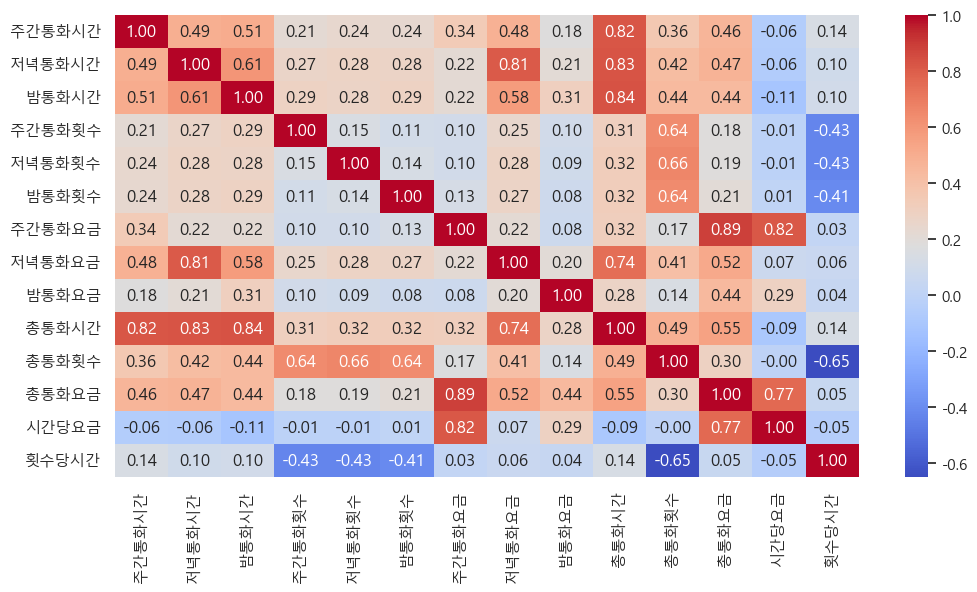

In [102]:
plt.figure(figsize=(12,6))
sns.heatmap(train[['주간통화시간', '저녁통화시간', '밤통화시간', '주간통화횟수','저녁통화횟수', '밤통화횟수',  '주간통화요금','저녁통화요금', '밤통화요금',
                   '총통화시간', '총통화횟수', '총통화요금', '시간당요금', '횟수당시간']].corr(), fmt=".2f", annot=True, cmap="coolwarm")
plt.show()

# 통화 시간,횟수,요금 (주간,야간,밤)

## 주간

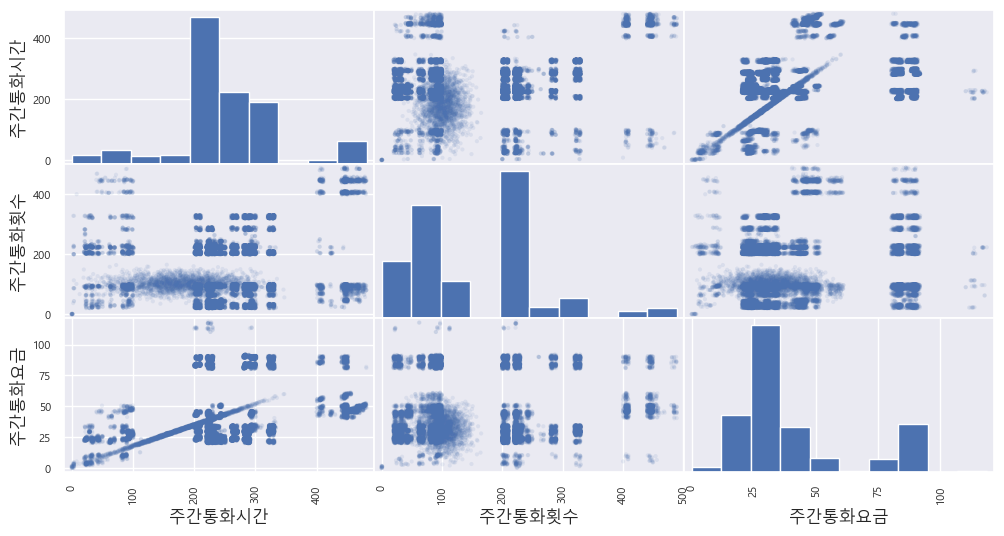

In [103]:
scatter_matrix(train[[ '주간통화시간', '주간통화횟수', '주간통화요금']], figsize=(12, 6), alpha=0.1)
plt.show()

## 저녁

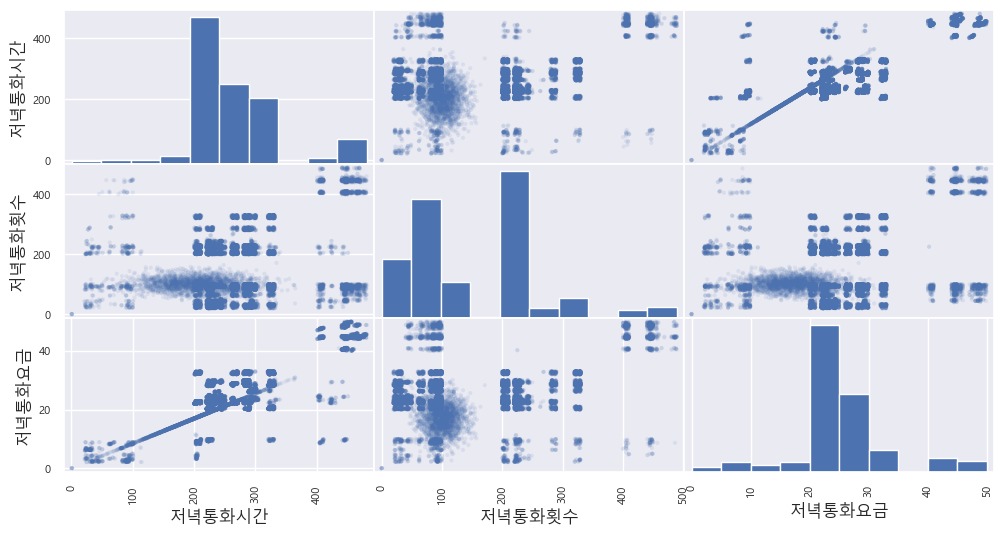

In [104]:
scatter_matrix(train[[  '저녁통화시간', '저녁통화횟수','저녁통화요금']], figsize=(12, 6), alpha=0.1)
plt.show()

## 밤

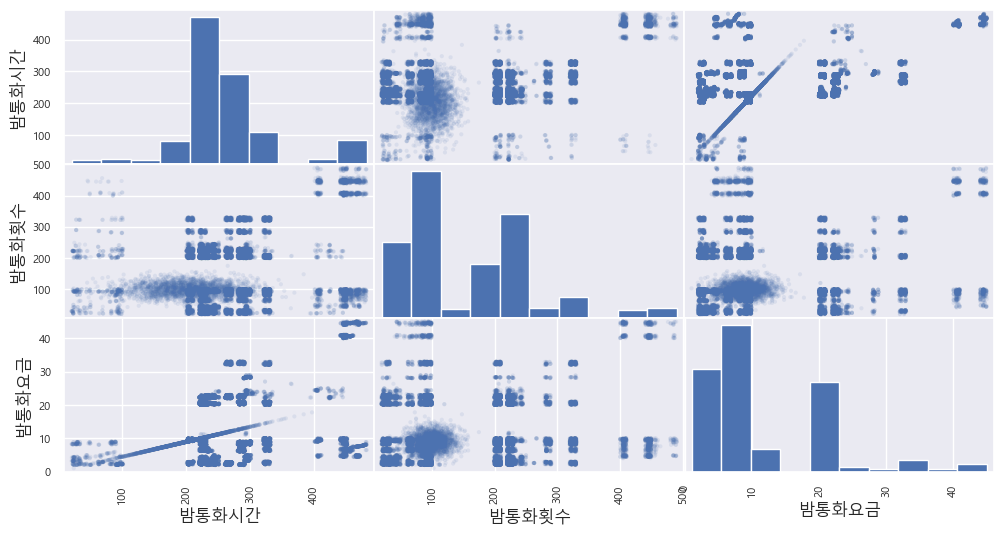

In [105]:
scatter_matrix(train[[ '밤통화시간', '밤통화횟수', '밤통화요금']], figsize=(12, 6), alpha=0.1)
plt.show()

# KMeans군집화 (비지도학습)
* 해지 고객의 뚜렷한 특징 피쳐가 없어 클러스터링 시도

In [122]:
from sklearn.cluster import KMeans 
X_train = train.drop(['전화해지여부'], axis=1)
km = KMeans(n_clusters=5, random_state=42).fit(X_train)
train['cluster'] = km.predict(X_train)
test['cluster'] = km.predict(test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 가입일
- 밤통화횟수
- 상담전화건수
- 주간통화횟수


In [ ]:
train['cluster'].value_counts().sort_index() 

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot( data=train, x='cluster', y='가입기간월', hue='전화해지여부')
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='총통화시간', y='가입기간월', data=train, hue="cluster", palette='Set2')

plt.subplot(132)
sns.scatterplot(x='시간당요금', y='가입기간월', data=train, hue="cluster", palette='Set2')

# # plt.subplot(133)
# sns.scatterplot(x='총통화시간', y='시간당요금', data=train, hue="cluster", palette='Set2')

In [ ]:
# plt.subplot(133)
sns.scatterplot(x='총통화시간', y='시간당요금', data=train, hue="cluster", palette='Set2')

* ref : https://tobigs.gitbook.io/tobigs/data-analysis/undefined-3/python-2-1

In [ ]:
# ! pip install scipy

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [ ]:
# # 왼쪽은 scaling 적용 X 데이터, 오른쪽은 scaling 적용 O 데이터
# # 순서대로 single linkage, complete linkage, average linkage, centroid linkage, ward linkage 적용해보았다.
# # 거리를 기준으로 proximity matrix를 만들고 이에 따라 cluster를 키워 나가는데,
# # 군집 간 거리를 측정하는 방식이 달라지니 군집화가 이루어진 결과도 확연히 차이가 났다.
# linkage_list = ['centroid','average']  # 'single', 'complete', 'centroid', 'ward']
# data = [train]
# fig, axes = plt.subplots(nrows=len(linkage_list), ncols=2, figsize=(16, 35))
# for i in range(len(linkage_list)):
#     for j in range(len(data)):
#         hierarchical_single = linkage(data[j], method=linkage_list[i])
#         dn = dendrogram(hierarchical_single, ax=axes[i][j])
#         axes[i][j].title.set_text(linkage_list[i])
# plt.show()

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='average')
# labels = agg_clustering.fit_predict(train)

# DAVinCI LABS군집화 (지도학습)
* 타겟과 통계적으로 거리가 먼 데이터 클러스터링 -- 어떻게 하는지 모르겠음

# Threshold 조정

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from scikitplot.metrics import  plot_roc_curve, plot_precision_recall_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
a = train[train['전화해지여부']==0].describe().T
b = train[train['전화해지여부']==1].describe().T

df = pd.concat([a,b],axis=1)
df.head()

In [ ]:
y_s=train['전화해지여부']
X_s=train.drop(['가입일', '주간통화시간', '주간통화횟수', '주간통화요금', '밤통화횟수', '상담전화건수','전화해지여부'],axis=1)
from imblearn.over_sampling import SMOTE
X_o, y_o = SMOTE(sampling_strategy='auto', random_state=2021).fit_resample(X_s,y_s)
print(  len(X_s), len(y_s) )

y_s.value_counts()

In [ ]:
model = RandomForestClassifier(random_state=0)
Xo_tr, Xo_ts,yo_tr,yo_ts = train_test_split(X_o,y_o,test_size=0.2,random_state=0)
model.fit(Xo_tr, yo_tr)
brz = Binarizer(threshold=0.25)
th_pred = brz.fit_transform(Xo_ts).reshape(-1, 1)
yo_pred = model.predict(Xo_ts)
# proba = model.predict_proba(Xo_ts)
score_over = accuracy_score(yo_ts, yo_pred)
f1_over        = f1_score(yo_ts, yo_pred, average='binary')
precision_over = precision_score(yo_ts, yo_pred, average='binary')
recall_over    = recall_score(yo_ts, yo_pred, average='binary')

# print( roc_auc_score(yo_ts, proba, multi_class="ovr", average="macro") )
print(confusion_matrix(yo_ts, yo_pred) )
print(f"accuracy : {score_over:.5f} / f1 : {f1_over:.5} / precision : {precision_over:.5} / recall : {recall_over:.5}")

In [ ]:
test = test.drop([ '가입일', '주간통화횟수', '밤통화횟수', '상담전화건수'],axis=1)

In [ ]:
train.shape, test.shape

In [ ]:
submit_arr = model.predict(test)
submit_csv = pd.read_csv('./datasets/sample_submission.csv')
submit_csv['전화해지여부'] = submit_arr
submit_csv.to_csv('./submit7.csv', index=False)

#  파생변수와 다중공선을 보이는 컬럼 삭제

# 아웃라이어 삭제

# 인코딩 & 스케일링